In [42]:
import json
import os
from pandas import DataFrame as df
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# read files

In [43]:
IMPORT_PATH = "../data_enflate_cleaned"
filenames = os.listdir(IMPORT_PATH)
filenames = [file for file in filenames if file.endswith(".json")]
filename_list = [IMPORT_PATH + "/" + filename for filename in filenames]
devices_data = {}
for file in filename_list:
    device_data = pd.read_json(file)
    #print(device_data.head())
    devices_data[file] = device_data

In [44]:
devices_data_working = {name:d.copy() for name, d in devices_data.items()}
devices_data_small = devices_data.copy()
#print(devices_data_working.keys())
print(f"found {len(devices_data_working.keys())} devices")

date_limit = pd.Timestamp("2024-08-30")

allowed_headers = ["Device", "Timestamp", "L1_min_current", "L1_max_current", "L1_avg_current", "relay_state", "L1_active_energy_diff"]
for name, device in devices_data_working.items():
    headers = device.columns
    #print(headers)

    # delete all colums not in headers
    for column in device.columns:
        if column not in allowed_headers:
            del device[column]

    # delete all rows with timestamp <  date_limit
    device = device[device["Timestamp"] > date_limit]
    print(name)
    print(device.head())

    device.to_csv(name + ".csv")


found 50 devices
../data_enflate_cleaned/site_1106.json
       Device           Timestamp  L1_avg_current  L1_max_current  \
28046  Boiler 2024-08-30 00:00:20              59              93   
28047  Boiler 2024-08-30 00:00:50              57              85   
28048  Boiler 2024-08-30 00:01:20              60              88   
28049  Boiler 2024-08-30 00:01:50              54              90   
28050  Boiler 2024-08-30 00:02:20              59              95   

       L1_min_current  relay_state  L1_active_energy_diff  
28046              45            1               0.000000  
28047              45            1               0.033333  
28048              48            1               0.000000  
28049              45            1               0.033333  
28050              45            1               0.000000  
../data_enflate_cleaned/site_1410_add_heat_add_heat.json
            Device           Timestamp  L1_avg_current  L1_max_current  \
22245  Add.Heating 2024-08-30 00:00:40

# Calculate KPIs

## Anzahl Schaltungen

In [45]:
def calculate_switching_count(device_data) -> int:
    """loop over df and count the number of times the L1_min_voltage differs from L1_max_voltage"""
    switching_count = 0
    for index, row in device_data.iterrows():
        # diff smaler 1 ampere
        if abs(row["L1_min_current"] - row["L1_max_current"]) > 50:
            switching_count += 1

    # TODO: pmean per day
        
    return switching_count

## respects Rundsteuerung
Device stays turned of during the full period

In [46]:
def respects_signal(device_data, diff_limit) -> bool:
    """check if the device respects the signal relay_state"""

    # plot L1_active_energy over time, limit max valuer to 50
    # device_data.plot(x="Timestamp", y="L1_active_energy_diff", ylim=(0, 5000))

    conflict_count = 0
    correct_count = 0
    respects_signal = True
    for index, row in device_data.iterrows():
        if row["relay_state"] == 0 and row["L1_active_energy_diff"] > diff_limit:
            conflict_count += 1
        if row["relay_state"] == 0 and row["L1_active_energy_diff"] < diff_limit:
            correct_count += 1
    print(f"conflict_count: {conflict_count} correct_count: {correct_count} ratio: {conflict_count*100/correct_count}%")
    # tolerating 1% of conflicting
    if conflict_count/correct_count > 0.01:
        respects_signal = False
    return respects_signal



## react to Rundsteuernung

In [84]:
def reacts_to_signal(device_data, device_name):# -> react_count_on_block_count, react_count_on_release_count:
    """check if the device reacts to a signal"""

    SWITCH_DIFFERENCE = 100

    count_block_signal = 0
    count_release_signal = 0
    signal_point_0 = 0
    signal_point_1 = 0

    react_count_on_block_count = 0
    react_count_on_release_count = 0

    for index, row in device_data.iterrows():

        if row["Timestamp"].date() < pd.Timestamp("2024-08-31").date():
            continue

        # start not from beginning
        if index > 5 and index < len(device_data) - 5:
            signal_point_1 = row["relay_state"]

            # if row["Timestamp"].date() == pd.Timestamp("2024-08-31").date():
                # print(f"device_name {device_name}  {row['Timestamp']} {row['relay_state']} {row['L1_active_energy_diff']}")
            
            # from now consumption blocked
            if signal_point_0 > signal_point_1:
                count_block_signal += 1
                # if date is 31.8.2024 00:00:00
                # print(f"--------------")
                # print(f"device_name {device_name}  {device_data.iloc[index - 2]['Timestamp']}   {device_data.iloc[index - 2]['relay_state']}   {device_data.iloc[index - 2]['L1_avg_current']}")
                # print(f"device_name {device_name}  {device_data.iloc[index - 1]['Timestamp']}   {device_data.iloc[index - 1]['relay_state']}   {device_data.iloc[index - 1]['L1_avg_current']}")
                # print(f"device_name {device_name}  {device_data.iloc[index - 0]['Timestamp']}   {device_data.iloc[index - 0]['relay_state']}   {device_data.iloc[index - 0]['L1_avg_current']}")
                # print(f"device_name {device_name}  {device_data.iloc[index + 1]['Timestamp']}   {device_data.iloc[index + 1]['relay_state']}   {device_data.iloc[index + 1]['L1_avg_current']}")
                # print(f"device_name {device_name}  {device_data.iloc[index + 1]['Timestamp']}   {device_data.iloc[index + 1]['relay_state']}   {device_data.iloc[index + 2]['L1_avg_current']}")

                L1_active_energy_diff_minus_2 = device_data.iloc[index - 2]["L1_avg_current"]
                L1_active_energy_diff_plus_2 = device_data.iloc[index + 2]["L1_avg_current"]

                # detect cunsumption switch
                if ( L1_active_energy_diff_minus_2 - L1_active_energy_diff_plus_2 ) > SWITCH_DIFFERENCE:
                    react_count_on_block_count += 1
                    # print(f"device_name {device_name}  {device_data.iloc[index - 2]['Timestamp']}   {device_data.iloc[index - 2]['relay_state']}   {device_data.iloc[index - 2]['L1_active_energy_diff']}")
                    # print(f"device_name {device_name}  {device_data.iloc[index - 1]['Timestamp']}   {device_data.iloc[index - 1]['relay_state']}   {device_data.iloc[index - 1]['L1_active_energy_diff']}")
                    # print(f"device_name {device_name}  {device_data.iloc[index - 0]['Timestamp']}   {device_data.iloc[index - 0]['relay_state']}   {device_data.iloc[index - 0]['L1_active_energy_diff']}")
                    # print(f"device_name {device_name}  {device_data.iloc[index + 1]['Timestamp']}   {device_data.iloc[index + 1]['relay_state']}   {device_data.iloc[index + 1]['L1_active_energy_diff']}")
                    # print(f"device_name {device_name}  {device_data.iloc[index + 1]['Timestamp']}   {device_data.iloc[index + 1]['relay_state']}   {device_data.iloc[index + 2]['L1_active_energy_diff']}")
                # else:
                #     react_count_on_release_count += 1
            
            # from now cunsomption allowed
            elif signal_point_0 < signal_point_1:
                count_release_signal += 1
                # print(f"--------------")
                # print(f"device_name {device_name}  {device_data.iloc[index - 2]['Timestamp']}   {device_data.iloc[index - 2]['relay_state']}   {device_data.iloc[index - 2]['L1_avg_current']}")
                # print(f"device_name {device_name}  {device_data.iloc[index - 1]['Timestamp']}   {device_data.iloc[index - 1]['relay_state']}   {device_data.iloc[index - 1]['L1_avg_current']}")
                # print(f"device_name {device_name}  {device_data.iloc[index - 0]['Timestamp']}   {device_data.iloc[index - 0]['relay_state']}   {device_data.iloc[index - 0]['L1_avg_current']}")
                # print(f"device_name {device_name}  {device_data.iloc[index + 1]['Timestamp']}   {device_data.iloc[index + 1]['relay_state']}   {device_data.iloc[index + 1]['L1_avg_current']}")
                # print(f"device_name {device_name}  {device_data.iloc[index + 1]['Timestamp']}   {device_data.iloc[index + 1]['relay_state']}   {device_data.iloc[index + 2]['L1_avg_current']}")
                L1_active_energy_diff_minus_2 = device_data.iloc[index - 2]["L1_avg_current"]
                L1_active_energy_diff_plus_2 = device_data.iloc[index + 2]["L1_avg_current"]

                # detect cunsumption switch
                if ( L1_active_energy_diff_plus_2 - L1_active_energy_diff_minus_2 ) > SWITCH_DIFFERENCE:
                    react_count_on_release_count += 1
                    # print(f"device_name {device_name}  {device_data.iloc[index - 2]['Timestamp']}   {device_data.iloc[index - 2]['relay_state']}   {device_data.iloc[index - 2]['L1_active_energy_diff']}")
                    # print(f"device_name {device_name}  {device_data.iloc[index - 1]['Timestamp']}   {device_data.iloc[index - 1]['relay_state']}   {device_data.iloc[index - 1]['L1_active_energy_diff']}")
                    # print(f"device_name {device_name}  {device_data.iloc[index - 0]['Timestamp']}   {device_data.iloc[index - 0]['relay_state']}   {device_data.iloc[index - 0]['L1_active_energy_diff']}")
                    # print(f"device_name {device_name}  {device_data.iloc[index + 1]['Timestamp']}   {device_data.iloc[index + 1]['relay_state']}   {device_data.iloc[index + 1]['L1_active_energy_diff']}")
                    # print(f"device_name {device_name}  {device_data.iloc[index + 1]['Timestamp']}   {device_data.iloc[index + 1]['relay_state']}   {device_data.iloc[index + 2]['L1_active_energy_diff']}")

                # else:
                #     react_count_on_release_count += 1

        # rollover values
        signal_point_0 = signal_point_1

    print (f"{device_name} count_block_signal {count_block_signal}")
    print (f"{device_name} count_release_signal {count_release_signal}")

    
    return react_count_on_block_count, react_count_on_release_count
    # # make decision
    # if react_count_on_block_count > 0:
    #     print(f"true react_count: {react_count} react_coureact_count_on_block_countnt_on_release_count: {react_count_on_release_count} ratio: {react_count*100/react_count_on_release_count}%")
    #     return True
    # else:
    #     print(f"false react_count: {react_count} react_count_on_release_count: {react_count_on_release_count} ratio: {react_count*100/react_count_on_release_count}%")
    #     return False
    

# calculate KPI loop

In [85]:
devices_kpis = {}
device_type_kpis = {}
device_feature_dict = {}
diff_limit = 50

for device_name, device_data in devices_data_working.items():
    device_kpis = {}
    #device_kpis["switching_count"] = calculate_switching_count(device_data)
    #device_kpis["respects_signal"] = respects_signal(device_data, diff_limit)
    #if device_name == '../data_enflate_cleaned/site_6128.json':

    # if "6037" not in device_name:
    #     continue

    # Rundsteuerung reaction
    react_count_on_block_count, react_count_on_release_count = reacts_to_signal(device_data, device_name)
    device_kpis["react_count_on_block_count"] = react_count_on_block_count
    device_kpis["react_count_on_release_count"] = react_count_on_release_count

    # Device type
    device_kpis["Device"] = device_data["Device"].iloc[0]


    short_device_name = device_name.split("/")[-1].split(".")[0]
    # Print KPIs
    devices_kpis[short_device_name] = device_kpis
    print (f" {short_device_name} PKIs: {device_kpis}")

    # if device_kpis["Device"] not in device_type_kpis:
    #     device_type_kpis[device_kpis["Device"]] = {}
    # if "react_count_on_block_count_values" not in device_type_kpis[device_kpis["Device"]]:
    #     device_type_kpis[device_kpis["Device"]]["react_count_on_block_count_values"] = []
    # device_type_kpis[device_kpis["Device"]]["react_count_on_block_count_values"].append(device_kpis["react_count_on_block_count"])
    # if "react_count_on_release_count_values" not in device_type_kpis[device_kpis["Device"]]:
    #     device_type_kpis[device_kpis["Device"]]["react_count_on_release_count_values"] = []
    # device_type_kpis[device_kpis["Device"]]["react_count_on_release_count_values"].append(device_kpis["react_count_on_release_count"])
    
    # plot L1_min_voltage and L1_max_voltage
    # device_data.plot(x='Timestamp', y=['L1_min_current', 'L1_max_current'])

    if "react_count_on_block_counts" not in device_feature_dict:
        device_feature_dict["react_count_on_block_counts"] = {}
    if device_kpis["Device"] not in device_feature_dict["react_count_on_block_counts"]:
        device_feature_dict["react_count_on_block_counts"][device_kpis["Device"]] = []
    device_feature_dict["react_count_on_block_counts"][device_kpis["Device"]].append(device_kpis["react_count_on_block_count"])

    if "react_count_on_release_counts" not in device_feature_dict:
        device_feature_dict["react_count_on_release_counts"] = {}
    if device_kpis["Device"] not in device_feature_dict["react_count_on_release_counts"]:
        device_feature_dict["react_count_on_release_counts"][device_kpis["Device"]] = []
    device_feature_dict["react_count_on_release_counts"][device_kpis["Device"]].append(device_kpis["react_count_on_release_count"])


    

../data_enflate_cleaned/site_1106.json count_block_signal 16
../data_enflate_cleaned/site_1106.json count_release_signal 17
 site_1106 PKIs: {'react_count_on_block_count': 0, 'react_count_on_release_count': 0, 'Device': 'Boiler'}
../data_enflate_cleaned/site_1410_add_heat_add_heat.json count_block_signal 17
../data_enflate_cleaned/site_1410_add_heat_add_heat.json count_release_signal 17
 site_1410_add_heat_add_heat PKIs: {'react_count_on_block_count': 0, 'react_count_on_release_count': 0, 'Device': 'Add.Heating'}
../data_enflate_cleaned/site_1410_heatpump_heatpump.json count_block_signal 18
../data_enflate_cleaned/site_1410_heatpump_heatpump.json count_release_signal 18
 site_1410_heatpump_heatpump PKIs: {'react_count_on_block_count': 0, 'react_count_on_release_count': 0, 'Device': 'Heatpump'}
../data_enflate_cleaned/site_2019_heatpump_heatpump.json count_block_signal 18
../data_enflate_cleaned/site_2019_heatpump_heatpump.json count_release_signal 19
 site_2019_heatpump_heatpump PKIs: 

# Print statistics


Per device type and feature
----------------
{"react_count_on_block_counts": {"Add.Heating": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], "Boiler": [0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0], "Heatpump": [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0]}, "react_count_on_release_counts": {"Add.Heating": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "Boiler": [0, 11, 4, 6, 11, 9, 0, 8, 12, 0, 11, 10, 6, 8, 6, 12, 8, 0, 12, 0, 12], "Heatpump": [0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0]}}

Per device KPIs
----------------
feature: react_count_on_block_counts
device_feature_dict[feature]: {'Boiler': [0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0], 'Add.Heating': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'Heatpump': [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0]}


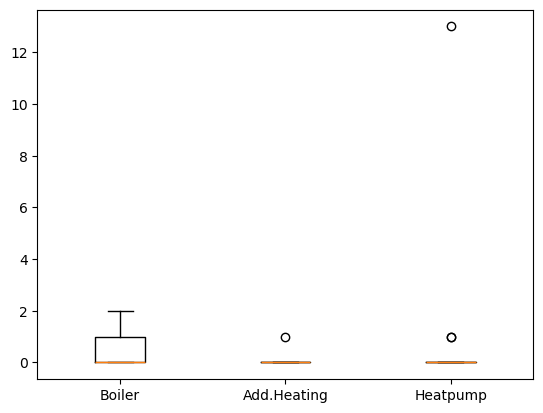

feature: react_count_on_release_counts
device_feature_dict[feature]: {'Boiler': [0, 11, 4, 6, 11, 9, 0, 8, 12, 0, 11, 10, 6, 8, 6, 12, 8, 0, 12, 0, 12], 'Add.Heating': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Heatpump': [0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0]}


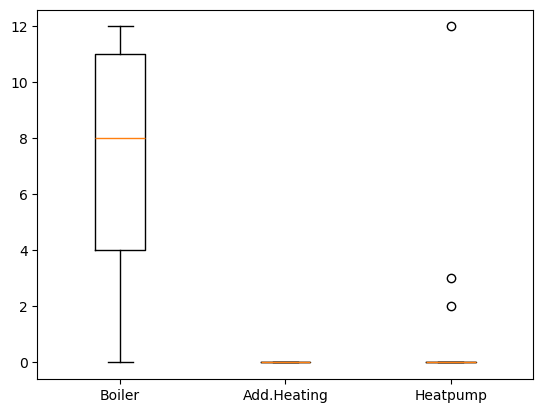

In [86]:

print("Per device type and feature")
print("----------------")
# print ( json.dumps( device_feature_dict, indent=4, sort_keys=True) )
print ( json.dumps( device_feature_dict, sort_keys=True) )


print("")
print("Per device KPIs")
print("----------------")
# print ( json.dumps( devices_kpis, sort_keys=True) )

# print boxplot from device_type_kpis
import matplotlib.pyplot as plt
import numpy as np

# how many times the device reacts to a signal
for feature in device_feature_dict.keys():
    print(f"feature: {feature}")
    print(f"device_feature_dict[feature]: {device_feature_dict[feature]}")
    fig, ax = plt.subplots()
    ax.boxplot(device_feature_dict[feature].values())
    ax.set_xticklabels(device_feature_dict[feature].keys())
    plt.show()

